In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import cv2 as cv
import glob
import yaml
import cv2
import time
import matplotlib
%matplotlib inline
matplotlib.rc('image', cmap = 'gray')

# ArUco Marker-Based Video Augmentation

(-0.5, 199.5, 199.5, -0.5)

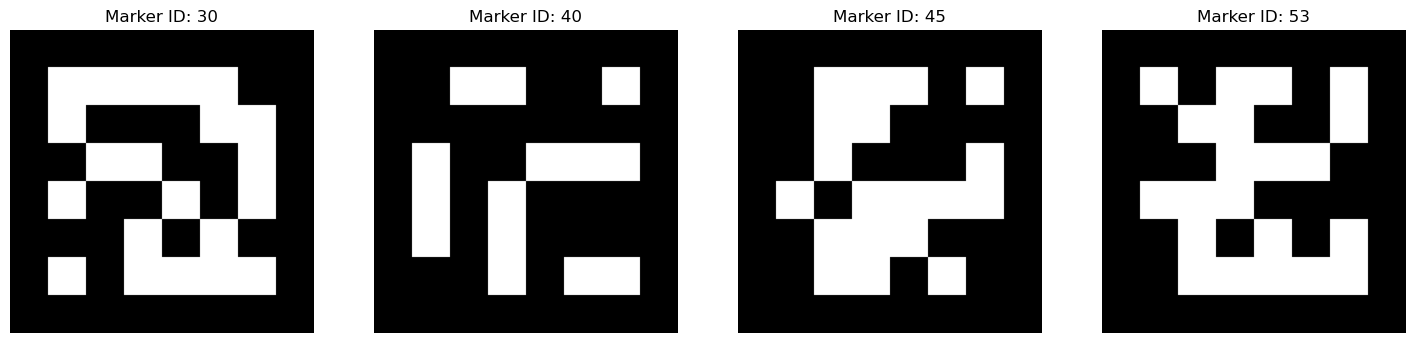

In [11]:
dictionary = cv.aruco.getPredefinedDictionary(cv.aruco.DICT_6X6_250)
# Generate markers with IDs: 23, 25, 30, and 33.
marker_image1 = cv.aruco.generateImageMarker(dictionary, 30, 200)
marker_image2 = cv.aruco.generateImageMarker(dictionary, 40, 200)
marker_image3 = cv.aruco.generateImageMarker(dictionary, 45, 200)
marker_image4 = cv.aruco.generateImageMarker(dictionary, 53, 200)

# Display the markers.
plt.figure(figsize = [18, 10])
plt.subplot(1,4,1); plt.imshow(marker_image1); plt.title("Marker ID: 30"); plt.axis('off')
plt.subplot(1,4,2); plt.imshow(marker_image2); plt.title("Marker ID: 40"); plt.axis('off')
plt.subplot(1,4,3); plt.imshow(marker_image3); plt.title("Marker ID: 45"); plt.axis('off')
plt.subplot(1,4,4); plt.imshow(marker_image4); plt.title("Marker ID: 53"); plt.axis('off')


In [49]:
# Function to extract reference point coordinates
def extract_corner_points (ids, ref_points, corners):
    ref_pt1, ref_pt2, ref_pt3, ref_pt4 = ref_points[:4]
    # Upper left corner of ROI
    index = np.squeeze(np.where(ids == 45))
    if index.size > 0:
        ref_pt1 = np.squeeze(corners[index[0]])[3]
    
    # Upper right corner of ROI
    index = np.squeeze(np.where(ids == 40))
    if index.size > 0:
        ref_pt2 = np.squeeze(corners[index[0]])[0]
    
    # Lower right corner of ROI
    index = np.squeeze(np.where(ids == 53))
    if index.size > 0:
        ref_pt3 = np.squeeze(corners[index[0]])[2]
    
    # Lower left corner of ROI
    index = np.squeeze(np.where(ids == 30))
    if index.size > 0:
        ref_pt4 = np.squeeze(corners[index[0]])[3]
    return ref_pt1, ref_pt2, ref_pt3, ref_pt4


# Function for scaled destination points
def scaled_roi(ref_pt1, ref_pt2, ref_pt3, ref_pt4, scaling_fac_x, scaling_fac_y):
    # Compute horizontal and vertical distance between markers.
    x_distance = np.linalg.norm(ref_pt1 - ref_pt2)
    y_distance = np.linalg.norm(ref_pt1 - ref_pt3)
    # Apply the scaling factors to the ArUco Marker reference points to make.
    # the final adjustment for the destination points.
    delta_x = round(scaling_fac_x * x_distance)
    delta_y = round(scaling_fac_y * y_distance)

    return [
        [ref_pt1[0] - delta_x, ref_pt1[1] - delta_y],
        [ref_pt2[0] + delta_x, ref_pt2[1] - delta_y],
        [ref_pt3[0] + delta_x, ref_pt3[1] + delta_y],
        [ref_pt4[0] - delta_x, ref_pt4[1] + delta_y]
    ]

In [50]:
import cv2
import numpy as np

# Load the ArUco dictionary and parameters
dictionary = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_6X6_250)
marker_ids = [45, 40, 53, 30]
ref_points = [[0, 0], [0, 0], [0, 0], [0, 0]]  # Convert tuple to mutable list
scaling_fac_x = 0.008
scaling_fac_y = 0.012

# Load the video to be augmented
cap_dst = cv2.VideoCapture('recorded_video.mp4')
cap_src = cv2.VideoCapture("replaced_video.mp4")

# Check if videos are loaded correctly
if not cap_dst.isOpened():
    print("Error: Could not open recorded_video.mp4")
    exit()
if not cap_src.isOpened():
    print("Error: Could not open replaced_video.mp4")
    exit()

# Get FPS, Width, Height
fps = cap_dst.get(cv2.CAP_PROP_FPS)
if fps == 0 or fps is None:
    fps = 30  # Default FPS

width = int(cap_dst.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap_dst.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Check if dimensions are valid
if width == 0 or height == 0:
    print("Error: Invalid video dimensions. Check input videos.")
    exit()

# Create video writer
output_file = 'Augmented_video.mp4'
video_writer = cv2.VideoWriter(output_file, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))


# Frame processing loop
frame_count = 0
while True:
    # Read frames
    dst_has_frame, frame_dst = cap_dst.read()
    if not dst_has_frame or frame_dst is None:
        print("Recorded video ended.")
        break

    src_has_frame, frame_src = cap_src.read()
    if not src_has_frame or frame_src is None:
        print("Replaced video ended, stopping augmentation.")
        break

    # Ensure frames are valid
    frame_dst = frame_dst.astype(np.uint8)
    frame_src = frame_src.astype(np.uint8)

    # Detect markers
    parameters = cv2.aruco.DetectorParameters()
    detector = cv2.aruco.ArucoDetector(dictionary, parameters)
    corners, ids, _ = detector.detectMarkers(frame_dst)

    # Extract reference points
    ref_pt1, ref_pt2, ref_pt3, ref_pt4 = extract_corner_points(ids, ref_points, corners)
    pts_dst = scaled_roi(ref_pt1, ref_pt2, ref_pt3, ref_pt4, scaling_fac_x, scaling_fac_y)
    
    # Define source and destination points
    pts_src = np.array([[0, 0], [frame_src.shape[1], 0], [frame_src.shape[1], frame_src.shape[0]], [0, frame_src.shape[0]]], dtype=np.float32)
    pts_dst_m = np.array(pts_dst, dtype=np.float32)

    # Homography calculation
    h, mask = cv2.findHomography(pts_src, pts_dst_m, cv2.RANSAC)
    warped_image = cv2.warpPerspective(frame_src, h, (frame_dst.shape[1], frame_dst.shape[0]))

    # Create mask
    mask = np.zeros_like(frame_dst, dtype=np.uint8)
    cv2.fillConvexPoly(mask, np.int32([pts_dst_m]), (255, 255, 255), cv2.LINE_AA)

    mask_inv = cv2.bitwise_not(mask)
    frame_masked = cv2.bitwise_and(frame_dst, mask_inv)
    frame_out = cv2.add(warped_image, frame_masked)

    # Ensure both images have the same format before writing
    frame_out = frame_out.astype(np.uint8)

    # Write frame to output video
    video_writer.write(frame_out)
    
    print(f"Writing frame {frame_count}")
    frame_count += 1

# Release resources
cap_dst.release()
cap_src.release()
video_writer.release()
cv2.destroyAllWindows()
print("Processing complete, video writer released.")


Writing frame 0
Writing frame 1
Writing frame 2
Writing frame 3
Writing frame 4
Writing frame 5
Writing frame 6
Writing frame 7
Writing frame 8
Writing frame 9
Writing frame 10
Writing frame 11
Writing frame 12
Writing frame 13
Writing frame 14
Writing frame 15
Writing frame 16
Writing frame 17
Writing frame 18
Writing frame 19
Writing frame 20
Writing frame 21
Writing frame 22
Writing frame 23
Writing frame 24
Writing frame 25
Writing frame 26
Writing frame 27
Writing frame 28
Writing frame 29
Writing frame 30
Writing frame 31
Writing frame 32
Writing frame 33
Writing frame 34
Writing frame 35
Writing frame 36
Writing frame 37
Writing frame 38
Writing frame 39
Writing frame 40
Writing frame 41
Writing frame 42
Writing frame 43
Writing frame 44
Writing frame 45
Writing frame 46
Writing frame 47
Writing frame 48
Writing frame 49
Writing frame 50
Writing frame 51
Writing frame 52
Writing frame 53
Writing frame 54
Writing frame 55
Writing frame 56
Writing frame 57
Writing frame 58
Writing

You can see the resulted video Augmented_video.mp4